# Get slope data given lat and lon 

## We will use slope data from https://www.landfire.gov/version_download.php# 

In [55]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [5]:
#File paths
data_path      = '/Users/hrh/Desktop/AI/erdos/rapower_data/'
ca_gridpath    = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data_including_land_cover.csv'
slope_datapath = data_path + 'LF2020_SlpD_220_CONUS/'

### Read lats and lons for CA into a GeoDataframe

In [2]:
df_main             = pd.read_csv(ca_gridpath)
ca_grid             = df_main.loc[df_main['State']=='CA']
ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid_usable['Latitude'], ca_grid_usable['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))

((32.61826367503021, 41.98152421968207),
 (-124.36136888868832, -114.14033495079964))

In [10]:
# Create a GeoDataFrame for California coordinates
geometry = [Point(xy) for xy in ca_coords]
# ca_gdf   = gpd.GeoDataFrame(geometry=geometry)
ca_gdf   = gpd.GeoDataFrame({
    'geometry': [Point(lon, lat) for lat, lon in ca_coords]
}, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system
ca_gdf

,geometry
0,POINT (-122.27153 37.84717)
1,POINT (-121.56023 37.15445)
2,POINT (-122.14264 38.08989)
3,POINT (-122.72552 38.43000)
4,POINT (-122.74499 38.45912)
...,...
3672,POINT (-114.35780 34.29379)
3673,POINT (-114.35780 34.39236)
3674,POINT (-114.24907 34.19523)
3675,POINT (-114.24907 34.29379)


### Read slope data 

In [15]:
#Slope data path 
slope_tif_path = slope_datapath + 'Tif/LC20_SlpD_220.tif'
# Open the slope raster
# Check the CRS of the GeoDataFrame and the Raster
with rasterio.open(slope_tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster Bounds: {src.bounds}")

print(f"GeoDataFrame CRS: {ca_gdf.crs}")

Raster CRS: EPSG:5070
Raster Bounds: BoundingBox(left=-2362395.0, bottom=221265.0, right=2327655.0, top=3267405.0)
GeoDataFrame CRS: EPSG:4326


In [22]:
with rasterio.open(slope_tif_path) as src:
    #Convert the ca_gdf dataframe to the crs of the source
    ca_gdf = ca_gdf.to_crs(src.crs)
    # Mask the raster with the GeoDataFrame to get the slope values for California coordinates
    # out_image, out_transform = mask(src, [g for g in ca_gdf['geometry'].values], crop=True)
    # ca_slope_data            = out_image[0]  # Assuming slope data is in the first band
    # Sample the raster at the given points
    ca_slope_values = [val[0] for val in src.sample([(geom.x, geom.y) for geom in ca_gdf.geometry])]


In [26]:
len(ca_slope_values)

3677

In [29]:
# Create a DataFrame from the sampled slope values
ca_slope = pd.DataFrame({
    'lat': [geom.y for geom in ca_gdf.geometry],
    'lon': [geom.x for geom in ca_gdf.geometry],
    'slope': ca_slope_values
})

In [37]:
ca_slope

,lat,lon,slope
0,1.960197e+06,-2.260812e+06,1
1,1.868657e+06,-2.221735e+06,9
2,1.983319e+06,-2.242613e+06,2
3,2.033848e+06,-2.280725e+06,0
4,2.037451e+06,-2.281435e+06,0
...,...,...,...
3672,1.409284e+06,-1.666544e+06,27
3673,1.420099e+06,-1.664429e+06,8
3674,1.396567e+06,-1.658898e+06,1
3675,1.407383e+06,-1.656795e+06,9


###  Convert the DataFrame back to a GeoDataFrame with the original CRS (EPSG:4326)

In [45]:
#CRS transformation after creating a geodata frame
ca_slope_gdf = gpd.GeoDataFrame(ca_slope, geometry=gpd.points_from_xy(ca_slope.lon, ca_slope.lat),crs='EPSG:5070') # Set to raster's CRS to match the sampling
print('The coordinate reference system of ca_slope_gdf is:',ca_slope_gdf.crs)

# Now, reproject to EPSG:4326
ca_slope_gdf = ca_slope_gdf.to_crs("EPSG:4326")
print('The coordinate reference system of ca_slope_gdf is:',ca_slope_gdf.crs)

# Assuming 'ca_slope_gdf' has been correctly reprojected to EPSG:4326
ca_slope_gdf['lat'] = ca_slope_gdf.geometry.y
ca_slope_gdf['lon'] = ca_slope_gdf.geometry.x

The coordinate reference system of ca_slope_gdf is: EPSG:5070
The coordinate reference system of ca_slope_gdf is: EPSG:4326


In [47]:
# Verify the transformation
ca_slope_gdf

,lat,lon,slope,geometry
0,37.847173,-122.271530,1,POINT (-122.27153 37.84717)
1,37.154450,-121.560230,9,POINT (-121.56023 37.15445)
2,38.089888,-122.142635,2,POINT (-122.14264 38.08989)
3,38.430002,-122.725525,0,POINT (-122.72552 38.43000)
4,38.459120,-122.744989,0,POINT (-122.74499 38.45912)
...,...,...,...,...
3672,34.293795,-114.357804,27,POINT (-114.35780 34.29379)
3673,34.392355,-114.357804,8,POINT (-114.35780 34.39236)
3674,34.195234,-114.249069,1,POINT (-114.24907 34.19523)
3675,34.293795,-114.249069,9,POINT (-114.24907 34.29379)


### Finally, load the CA shape file and check if the slope information makes sense by plotting 

EPSG:4326


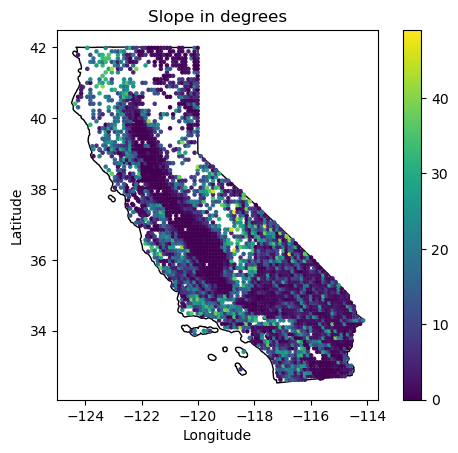

In [64]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the slope data
ca_slope_gdf.plot(ax=plt.gca(), column='slope', legend=True, markersize=5, cmap='viridis')

plt.title('Slope in degrees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finally, save the dataframe to a csv file after dropping the 'geometry' column

In [65]:
# Save to CSV
ca_slope_gdf.drop(columns='geometry').to_csv('ca_slope.csv', index=False)

In [67]:
#Check
ca_slope_check = pd.read_csv('ca_slope.csv')
ca_slope_check

,lat,lon,slope
0,37.847173,-122.271529,1
1,37.154450,-121.560230,9
2,38.089888,-122.142635,2
3,38.430002,-122.725525,0
4,38.459120,-122.744989,0
...,...,...,...
3672,34.293795,-114.357804,27
3673,34.392355,-114.357804,8
3674,34.195234,-114.249069,1
3675,34.293795,-114.249069,9
